## Intermediate Machine Learning: Assignment 2

**Deadline**

Assignment 2 is due Thursday, October  9 by 11:59 pm. Late work will not be accepted as per the course policies (see the syllabus on Canvas).

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Acknowledge any use of an AI system such as ChatGPT or Copilot.

You should start early so that you have time to get help if you're stuck. The drop-in office hours schedule can be found on Canvas. You can also post questions or start discussions on Ed Discussion. The assignment may look long at first glance, but the problems are broken up into steps that should help you to make steady progress.

**Submission**

Submit your assignment as a .pdf on Gradescope. To convert your notebook to a .pdf while preserving the cell structure without truncating the output, you can convert to .html using [this notebook](https://colab.research.google.com/github/YData123/sds365-fa25/blob/main/assignments/Convert_ipynb_to_HTML_in_Colab.ipynb). Note: When submitting on Gradescope, please select the correct pages of your pdf that correspond to each problem. This will allow graders to more easily find your complete solution to each problem.

**Topics**

 * Convolutional neural nets
 * Gaussian processes
 * Double descent

Please note that while the problems may look long, we give you substantial starter code to make the work manageable. The course staff members are available to help during office hours!

## Problem 1: Dilation elation (35 points)

### Overview

A dilated convolution (also known as atrous convolution) inserts gaps between kernel entries, so that a $k \times k$ filter “jumps” by a dilation rate $𝑑$. A dilation rate of $d=1$ is the regular convolution. CNN dilation can be adjusted using parameter $d$ as shown in the figure below.  



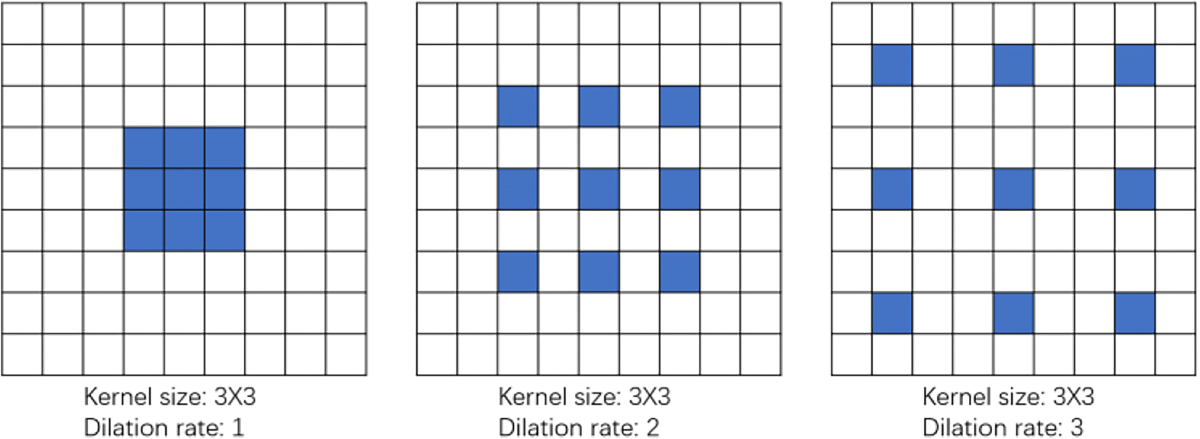




Dilated convolution captures a wider area of the input, allowing for potentially better context modeling without increased computational cost. It expands the effective "receptive field" (the area of the filter) without the need for larger kernels or more model parameters; dilated convolution can also reduce blurring. One of the most successful uses of  dilated convolution was in the first AlphaFold paper, one of the earliest CNN-based attempts to predict the structure of proteins. For a glimpse of the full architecture and its details you may wish to take a look at https://www.nature.com/articles/s41586-019-1923-7

In this problem, we use dilated convolution to analyze MRI images to detect the presence of certain types of brain tumors. Cues about tumor type can include texture information (enhanced rim, necrotic core) and global characteristics (edema extent, mass effect, midline shift). Dilation expands the effective receptive field while keeping high-resolution features available for downstream neural network layers that make the multi-class decision. This approach is also helps address the problem of "anisotropy" where some characteristics are directionally dependent, by trying to incorporate a larger sub image in the kernel.

In the first part of this problem, we implement a regular CNN. Then, your job will be to implement a dilated CNN, and to choose the dilation parameters so that the model is as accurate as you can make it.  Finally, we use Monte Carlo dropout as a way to estimate the uncertainty in the predictions.

### Dilated convolution in one and two dimensions

**Symbols (what each letter means):**
- $x$: the **input** (a 1D signal for the first formula; a 2D image for the second).
- $y$: the **output feature map** after convolution (same shape type as $x$).
- $w \in \mathbb{R}^{k}$: a 1D **kernel/filter** of length $k$.
- $W \in \mathbb{R}^{k\times k}$: a 2D **kernel/filter** of size $k \times k$.
- $k$: **kernel size** (e.g., $k=3$ for a $3\times3$ kernel).
- $d$: **dilation rate** (how far apart the kernel taps are; $d=1$ is a standard convolution).
- $i,j$: spatial **indices** of the output $y$ (row/column).
- $m,u,v$: **indices inside the kernel** (1D: $m$, 2D: $u$ for rows, $v$ for cols).
- $u_c=\lfloor k/2\rfloor$, $v_c=\lfloor k/2\rfloor$: the **kernel center** offsets (so the kernel is centered).
- We assume **stride $=1$** and appropriate padding so indices are valid.


---
---


**1D dilated convolution** of a signal $x$ with kernel $w \in \mathbb{R}^{k}$ and dilation $d \in \mathbb{N}$:
$$
y[i] \;=\; \sum_{m=0}^{k-1} w[m]\; x\!\bigl(i + d\,m\bigr).
$$

**2D dilated convolution** of an image $x$ with kernel $W \in \mathbb{R}^{k\times k}$ and dilation $d$ (stride $1$).  
Let $u_c=\lfloor k/2\rfloor$ and $v_c=\lfloor k/2\rfloor$ denote the kernel center:
$$
y[i,j] \;=\; \sum_{u=0}^{k-1}\sum_{v=0}^{k-1}
W[u,v]\; x\!\bigl(i + d\,(u-u_c),\; j + d\,(v-v_c)\bigr).
$$

**Effective receptive field** of a $k\times k$ kernel with dilation $d$:
$$
k_{\text{eff}} \;=\; k + (k-1)\,(d-1).
$$

For example, for $k=3$ and $d=3$, we get $k_{\text{eff}}=7$.  
(When $d=1$, this reduces to the standard convolution.)

### Loading the MRI data

The data used in this problem is cropped from this Kaggle repository https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset.

We only use the data corresponding to glioma tumors and non-tumor images. You can access the data in a zip file at [https://github.com/YData123/sds365-fa25/tree/main/assignments/assn2/](https://github.com/YData123/sds365-fa25/tree/main/assignments/assn2/).
You will need to upload the data to your Google Drive.

The cell below gives Colab access to your Google Drive.


In [2]:
# Please do not edit this cell.
# Imports
import os, random, time, math, keras, json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers as L, models as M

# (Colab) Mount Google Drive
from google.colab import drive
if not os.path.ismount("/content/drive"):
  drive.mount("/content/drive")

Mounted at /content/drive


Now that we mounted Google Drive let's try visualizing images in the training data for the tumor and non-tumor classes.

In [3]:
# Do not edit this block.
# Point to the MRI/ folder that contains Training/ and Testing/
ROOT = "/content/drive/MyDrive/MRI"

TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR  = os.path.join(ROOT, "Testing")
CLASS_NAMES = ["glioma", "notumor"]  # expected two folders inside both training/ and testing/

# Validation of directory structure
def assert_dir(p):
    if not os.path.isdir(p):
        raise FileNotFoundError(f"Expected directory not found: {p}")

assert_dir(ROOT)
assert_dir(TRAIN_DIR)
assert_dir(TEST_DIR)

# Load image as grayscale for consistent viewing
def load_img_gray(path):
    img = Image.open(path).convert("L")  # force grayscale
    return img

# List image files in a folder
def count_images(folder):
    exts = ("*.jpg", "*.jpeg")
    files = []
    for e in exts:
        files.extend(glob(os.path.join(folder, e)))
    return sorted(files)

The data we have requires pre-processing in order to be fed to any neural networks. The inconsistencies in the size as you see in the above output becomes problematic during feeding the data to the network. In this block, we strive to solve that issue.

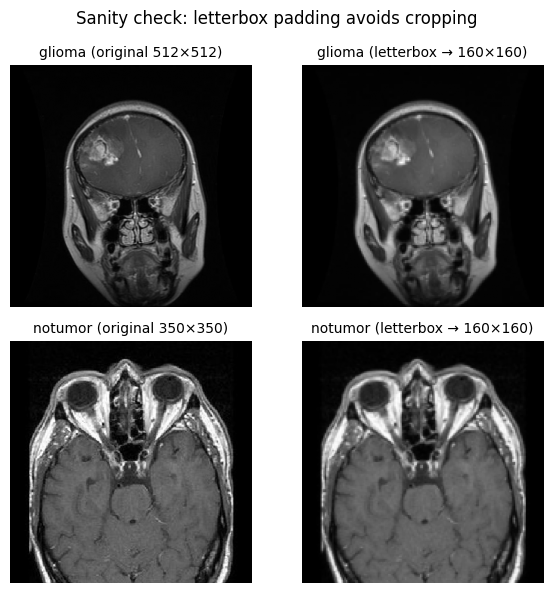

In [4]:
# Helper functions: letterbox pad to square (no cropping) + resize to 160x160

IMG_SIZE = 160  # target size used throughout the assignment

def letterbox_to_square(img: Image.Image, fill=0) -> Image.Image:
    """
    Pads the image to a square using 'fill' (black), centered, without distortion.
    Keeps original content intact (no cropping).
    """
    if img.mode not in ("L", "RGB"):
        img = img.convert("L")
    w, h = img.size
    s = max(w, h)
    canvas = Image.new(img.mode, (s, s), color=fill)
    canvas.paste(img, ((s - w)//2, (s - h)//2))
    return canvas

def preprocess_image(img: Image.Image, size: int = IMG_SIZE) -> Image.Image:
    """Letterbox pad -> resize to (size, size)."""
    sq = letterbox_to_square(img, fill=0)
    return sq.resize((size, size), resample=Image.BILINEAR)

# Visualize ORIGINAL vs PREPROCESSED (letterboxed) for first training image of each class
fig, axes = plt.subplots(len(CLASS_NAMES), 2, figsize=(6, 3*len(CLASS_NAMES)))
if len(CLASS_NAMES) == 1:
    axes = np.array([axes])  # ensure 2D array indexing

for i, c in enumerate(CLASS_NAMES):
    class_dir = os.path.join(TRAIN_DIR, c)
    files = count_images(class_dir)
    ax_orig, ax_proc = axes[i, 0], axes[i, 1]
    if not files:
        ax_orig.axis("off"); ax_proc.axis("off")
        ax_proc.set_title(f"No images found for {c}")
        continue

    p = files[0]
    img = load_img_gray(p)            # original grayscale
    proc = preprocess_image(img)      # padded + resized 160x160

    ax_orig.imshow(img, cmap="gray");  ax_orig.axis("off")
    ax_orig.set_title(f"{c} (original {img.size[0]}×{img.size[1]})", fontsize=10)

    ax_proc.imshow(proc, cmap="gray"); ax_proc.axis("off")
    ax_proc.set_title(f"{c} (letterbox → {IMG_SIZE}×{IMG_SIZE})", fontsize=10)

plt.suptitle("Sanity check: letterbox padding avoids cropping", fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
# Gather file paths & labels; split TRAIN into train/validation (TEST untouched)

def list_images_with_labels(root_dir, classes):
    paths, labels = [], []
    for ci, cname in enumerate(classes):
        cdir = os.path.join(root_dir, cname)
        for p in count_images(cdir):
            paths.append(p); labels.append(ci)
    return np.array(paths), np.array(labels)

# load TRAIN and TEST file lists
train_paths, train_labels = list_images_with_labels(TRAIN_DIR, CLASS_NAMES)
test_paths,  test_labels  = list_images_with_labels(TEST_DIR,  CLASS_NAMES)

# stratified split of TRAIN -> (train, val)
VAL_FRACTION = 0.20
tr_paths, val_paths, tr_labels, val_labels = train_test_split(
    train_paths, train_labels,
    test_size=VAL_FRACTION,
    random_state=42,
    stratify=train_labels
)

print(f"Counts -> train: {len(tr_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

Counts -> train: 2332, val: 584, test: 705


In [6]:
# TensorFlow input pipeline with the SAME preprocessing:
# grayscale -> letterbox to square (no crop) -> resize to IMG_SIZE -> per-image z-score

def tf_letterbox_resize(img, target=IMG_SIZE):
    shape = tf.shape(img)
    h, w = shape[0], shape[1]
    s = tf.maximum(h, w)
    pad_top  = (s - h) // 2
    pad_bottom = s - h - pad_top
    pad_left = (s - w) // 2
    pad_right = s - w - pad_left
    img_sq = tf.pad(img, [[pad_top, pad_bottom],[pad_left, pad_right],[0,0]], mode="CONSTANT", constant_values=0.0)
    img_rs = tf.image.resize(img_sq, (target, target), method="bilinear")
    return img_rs

def tf_per_image_zscore(img):
    mean = tf.reduce_mean(img)
    std  = tf.math.reduce_std(img)
    return (img - mean) / tf.maximum(std, 1e-6)

def load_and_preprocess(path, label, augment=False):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf_letterbox_resize(img, target=IMG_SIZE)

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.10)
        img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    img = tf_per_image_zscore(img)
    label = tf.cast(label, tf.float32)
    label = tf.expand_dims(label, axis=-1)   # (1,)
    return img, label

def make_dataset(paths, labels, batch_size=32, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(lambda p, y: load_and_preprocess(p, y, augment=augment),
                num_parallel_calls=tf.data.AUTOTUNE) #Maps map_func across the elements of this dataset.
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) # This allows later elements to be prepared while the current element is being processed.
                                                         #This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
    return ds

BATCH_SIZE = 16
ds_train = make_dataset(tr_paths,  tr_labels,  batch_size=BATCH_SIZE, shuffle=True,  augment=True)
ds_val   = make_dataset(val_paths, val_labels, batch_size=BATCH_SIZE, shuffle=False, augment=False)
ds_test  = make_dataset(test_paths, test_labels, batch_size=BATCH_SIZE, shuffle=False, augment=False)

for xb, yb in ds_train.take(1): #Creates a Dataset with at most count elements from this dataset.
    print("Train batch:", xb.shape, yb.shape)
for xb, yb in ds_test.take(1): #Creates a Dataset with at most count elements from this dataset.
    print("Test batch:", xb.shape, yb.shape)

Train batch: (16, 160, 160, 1) (16, 1)
Test batch: (16, 160, 160, 1) (16, 1)


/tmp/ipython-input-1886849759.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  c = int(yb[i])


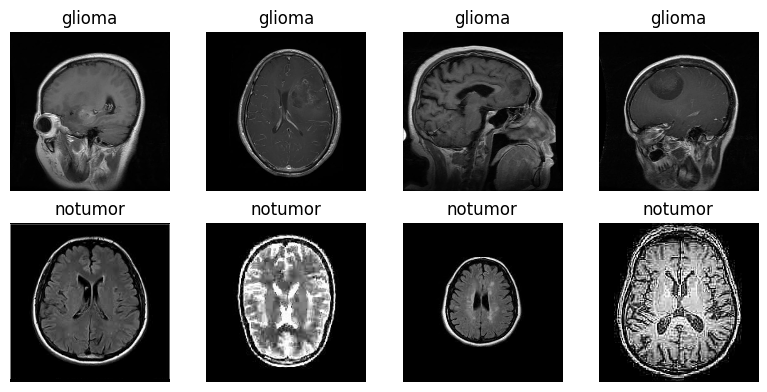

In [7]:
# Quick visual sanity check: Show 4 preprocessed samples per class from the TRAIN pipeline
class_names = CLASS_NAMES

# collect a small batch
xb, yb = next(iter(ds_train))
xb = xb.numpy(); yb = yb.numpy()

fig, axes = plt.subplots(2, 4, figsize=(8,4))
axes = axes.reshape(-1)
shown = {i:0 for i in range(len(class_names))}
for i in range(len(xb)):
    c = int(yb[i])
    if shown[c] >= 4:
        continue
    axes[c*4 + shown[c]].imshow(xb[i,...,0], cmap="gray")
    axes[c*4 + shown[c]].axis("off")
    axes[c*4 + shown[c]].set_title(class_names[c])
    shown[c]+=1
    if all(v==4 for v in shown.values()):
        break
plt.tight_layout(); plt.show()

In [8]:
"""
You'll learn two new layers in this assignment. MCSpatialDropout2D is a smarter type of dropout for image processing
networks. Instead of randomly turning off individual pixels, it turns off entire channels (feature detectors) all at
once. This works better for images because it prevents the network from getting too dependent on specific feature
detectors working together, which helps it generalize better to new data. BatchNormalization helps keep your network's
internal signals stable during training. It takes the outputs from each layer and normalizes them (resembling standardizing
data), then applies two learnable parameters to scale and shift the results as needed. This makes training more stable and
often lets you use higher learning rates, leading to faster and more reliable training.
"""
# Keras model factory: Build a baseline CNN
# Force-dropout layers that stay active at inference for MC sampling (BatchNorm stays frozen)
#The simplest way to implement Monte Carlo Dropout in TensorFlow is to ensure
#that the training argument in the Dropout layer's call method is set to True during inference.
@keras.saving.register_keras_serializable(package="mc")
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        # Force sampling masks even at inference for MC passes
        return super().call(inputs, training=True)

@keras.saving.register_keras_serializable(package="mc")
class MCSpatialDropout2D(tf.keras.layers.SpatialDropout2D):
    def call(self, inputs, training=None):
        # Force sampling masks even at inference for MC passes
        return super().call(inputs, training=True)

def build_cnn(
    dilated=False,
    dilations = (2,3,5),
    input_shape=(IMG_SIZE, IMG_SIZE, 1),
    num_classes=1,                # 1 sigmoid unit (binary)
    drop_rate=0.20,
    use_mc_dropout=True,          # if True, use MC* layers; else standard Dropout
    use_spatial=True              # SpatialDropout2D is usually better for convs
):
    """
    Tiny CNN; toggle dilation in block-2 convs. Adds dropout so MC sampling works.
    - dilated=False: Conv3x3 (rate=1)
    - dilated=True : dilation rates (2,3,5) in the 2nd conv of each block
    - Dropout: after each block; optionally before Dense head
    """
    if dilated:
        rates = dilations
    else:
        rates = (1,1,1)

    Drop = (MCSpatialDropout2D if (use_mc_dropout and use_spatial) else
            L.SpatialDropout2D if use_spatial else
            MCDropout if use_mc_dropout else
            L.Dropout)

    x_in = L.Input(shape=input_shape)
    x = x_in

    # Block A
    x = L.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32, 3, padding="same", activation="relu", dilation_rate=rates[0])(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPool2D(pool_size=2)(x)
    x = Drop(drop_rate)(x)  # <-- dropout for MC

    # Block B
    x = L.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(64, 3, padding="same", activation="relu", dilation_rate=rates[1])(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPool2D(pool_size=2)(x)
    x = Drop(drop_rate)(x)  # <-- dropout for MC

    # Block C
    x = L.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(128, 3, padding="same", activation="relu", dilation_rate=rates[2])(x)
    x = L.BatchNormalization()(x)
    x = Drop(drop_rate)(x)  # <-- dropout for MC

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = L.Dropout(drop_rate)(x)  # a small dense-level dropout is fine (standard)

    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # binary head
    model = tf.keras.Model(x_in, out)
    return model

# Rebuild models (students then train as in Step 14)
model_base = build_cnn(dilated=False)
model_base.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_spatial_dropout2d            │ (None, 80, 80, 32)     │             0 │
│ (MCSpatialDropout2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_spatial_dropout2d_1          │ (None, 40, 40, 64)     │             0 │
│ (MCSpatialDropout2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_spatial_dropout2d_2          │ (None, 40, 40, 128)    │             0 │
│ (MCSpatialDropout2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             

 Total params: 288,353 (1.10 MB)

 Trainable params: 287,457 (1.10 MB)

 Non-trainable params: 896 (3.50 KB)

### Problem 1.1: Explain the CNN

The cell above shows layer of the CNN, with the output tensor shape and the number of trainable parameters. For each layer, explain in a couple of sentences (1) what the purpose of the layer is (2) why the output shape and number of parameters are as shown.




*   Input Layer: feeding in an grayscale image with size (160$\times$160). The
number of channel is 1. So the output dimension is 160$\times$160$\times$1.

*   conv2d: Padding is used, so the convoluted image is still 160$\times$160 pixels. The dimension of one filter is 3$\times$3. There are 32 filters for convolution, so the output dimension is 160$\times$160$\times$32. The parameter number is (3$\times$3+1)$\times$32 = 320.

*   batch_normalization: For each channel, there are 4 parameters (mean, variance, scale and shift). Mean and variance are fixed. Scale and shift are trainable. The output dimension is unchanged. In total there are 32$\times$4 = 128 parameters.

*   conv2d_1: Padding is used, so the convoluted image is still 160$\times$160 pixels. The dimension of one filter is 3$\times$3$\times$32. There are 32 filters for convolution, so the output dimension is 160$\times$160$\times$32. The parameter number is (3$\times$3$\times$32+1)$\times$32 = 9248.

*   batch_normalization_1: The output dimension is unchanged. In total there are 32$\times$4 = 128 parameters.

*   max_pooling2d: Doing a 2$\times$2 max pooling. The output is (160/2)$\times$(160/2)$\times$32=80$\times$80$\times$32.

*   mc_spatial_dropout2d: Dropping out doesn't change the dimension of the output.

*   conv2d_2: The dimension of one filter is 3$\times$3$\times$32. There are 64 filters for convolution, so the output dimension is 80$\times$80$\times$64. The parameter number is (3$\times$3$\times$32+1)$\times$64 = 18496.

*   batch_normalization_2: The output dimension is unchanged. In total there are 64$\times$4 = 256 parameters.

*   conv2d_3: The dimension of one filter is 3$\times$3$\times$64. There are 64 filters for convolution, so the output dimension is 80$\times$80$\times$64. The parameter number is (3$\times$3$\times$64+1)$\times$64 = 36928.

*   batch_normalization_3: The output dimension is unchanged. In total there are 64$\times$4 = 256 parameters.

*   max_pooling2d_1: Doing a 2$\times$2 max pooling. The output is (80/2)$\times$(80/2)$\times$64=40$\times$40$\times$64.

*   mc_spatial_dropout2d_1: Dropping out doesn't change the dimension of the output.

*   conv2d_4: The dimension of one filter is 3$\times$3$\times$64. There are 128 filters for convolution, so the output dimension is 40$\times$40$\times$128. The parameter number is (3$\times$3$\times$64+1)$\times$128 = 73856.

*   batch_normalization_4: The output dimension is unchanged. In total there are 128$\times$4 = 512 parameters.

*   conv2d_5: The dimension of one filter is 3$\times$3$\times$128. There are 128 filters for convolution, so the output dimension is 40$\times$40$\times$128. The parameter number is (3$\times$3$\times$128+1)$\times$128 = 147584.

*   batch_normalization_5: The output dimension is unchanged. In total there are 128$\times$4 = 512 parameters.

*   mc_spatial_dropout2d_2: Dropping out doesn't change the dimension of the output.
*   global_average_pooling_2D: Global average pooling in TensorFlow is a pooling operation that computes the average of all values within each feature map, effectively reducing the spatial dimensions to 1x1. So each channel gives one number, the output is 128. Pooling needs no parameter.
*   dropout: Dropping out doesn't change the dimension of the output.
*   dense: A 128-by-1 matrix has 128 elements. The total parameters are 128 matrix elements plus 1 intercept = 129.







The following cell now trains the baseline CNN, and evaluates it on test data.

In [9]:
# Train the baseline model (with validation) + evaluate on TEST + plots

EPOCHS  = 10
OUTDIR  = "/content/outputs_cnn_dilation"
os.makedirs(OUTDIR, exist_ok=True)

def compile_model(m):
    m.compile(optimizer=tf.keras.optimizers.Adam(3e-5),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)])
    return m

def train_model(model, name, train_ds, val_ds, epochs=EPOCHS):
    ckpt = os.path.join(OUTDIR, f"{name}.keras")  # best checkpoint
    cbs = [ModelCheckpoint(ckpt, monitor="val_accuracy", save_best_only=True, verbose=1)]
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cbs, verbose=1)
    train_seconds = time.time() - t0
    print(f"[TIMER] {name}: training wall-clock = {train_seconds:.2f} sec "
          f"({train_seconds/max(1,len(hist.history['loss'])):.2f} sec/epoch) (monitoring val_accuracy)")
    # OPTIONAL: save the final weights separately (do NOT overwrite ckpt)
    final_path = os.path.join(OUTDIR, f"{name}_final.keras")
    model.save(final_path)
    return ckpt, hist, train_seconds

def evaluate_and_report(model, ds, class_names):
    y_true, y_pred = [], []
    out_last_dim = model.output_shape[-1]  # 1 for sigmoid, 2 for softmax
    for xb, yb in ds:
        probs = model.predict(xb, verbose=0)
        probs = np.array(probs).reshape((probs.shape[0], -1))
        preds = (probs[:,0] >= 0.5).astype(int) if out_last_dim == 1 else np.argmax(probs, axis=1)
        yt = yb.numpy().reshape(-1).astype(int)
        y_true.append(yt); y_pred.append(preds)
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return y_true, y_pred

def measure_eval_time(model, ds, n_samples):
    t0 = time.time()
    loss, acc = model.evaluate(ds, verbose=0)
    eval_seconds = time.time() - t0
    print(f"[TIMER] evaluate: {eval_seconds:.2f} sec")
    t1 = time.time()
    _ = model.predict(ds, verbose=0)
    pred_seconds = time.time() - t1
    ips = n_samples / pred_seconds if pred_seconds > 0 else float("inf")
    print(f"[TIMER] predict : {pred_seconds:.2f} sec  (~{ips:.1f} images/sec)")
    return loss, acc, eval_seconds, pred_seconds, ips

# --- compile
model_base = compile_model(model_base)

# --- train with validation (no test leakage)
ckpt_base, hist_base, train_time_base = train_model(model_base, "baseline_cnn", ds_train, ds_val, epochs=EPOCHS)

# --- reload best and evaluate on TEST (timed)
model_base = tf.keras.models.load_model(ckpt_base)

print("\n[TEST] Baseline:")
y_true_base, y_pred_base = evaluate_and_report(model_base, ds_test, CLASS_NAMES)
loss_b, acc_b, eval_t_b, pred_t_b, ips_b = measure_eval_time(model_base, ds_test, n_samples=len(test_paths))

print(f"\n[TEST] Baseline -> loss: {loss_b:.4f} | acc: {acc_b:.4f}")



Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5993 - loss: 0.6523
Epoch 1: val_accuracy improved from -inf to 0.45377, saving model to /content/outputs_cnn_dilation/baseline_cnn.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.5997 - loss: 0.6520 - val_accuracy: 0.4538 - val_loss: 1.0645
Epoch 2/10
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7312 - loss: 0.5321
Epoch 2: val_accuracy did not improve from 0.45377
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.7315 - loss: 0.5319 - val_accuracy: 0.4538 - val_loss: 1.1842
Epoch 3/10
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7739 - loss: 0.4954
Epoch 3: val_accuracy improved from 0.45377 to 0.58219, saving model to /content/outputs_cnn_dilation/baseline_cnn.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.7742 - loss: 0.4950 - val_accuracy: 0.5822 - val_loss: 0.7218
Epoch 4/10
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8313 - loss: 0.4026
Epoch 4: v

### Problem 1.2: Improve on the baseline with a dilated CNN

Your job is now to use the above code, appropriately modified as needed, to build and train a dilated CNN that has better accuracy than the baseline.

Note that the keras Conv2D method can handle dilation. You may experiment with any architecture (combination of layers) and dilation parameters that you wish.

To keep the notebook clear, only show your best model, not intermediate, experimental models. Explain your choice of model, and why your best dilation CNN model does or does not improve on the baseline. Note that you should use a runtime environment that uses a GPU for faster processing speed.

In [10]:
model_dila = build_cnn(dilated=True,dilations = (2,4,6))

# --- compile
model_dila = compile_model(model_dila)

# --- train with validation (no test leakage)
ckpt_dila, hist_dila, train_time_dila = train_model(model_dila, "Dilated246_cnn", ds_train, ds_val, epochs=EPOCHS)

# --- reload best and evaluate on TEST (timed)
model_dila = tf.keras.models.load_model(ckpt_dila)

print("\n[TEST] Dilated(2,4,6):")
y_true_dila, y_pred_dila = evaluate_and_report(model_dila, ds_test, CLASS_NAMES)
loss_d, acc_d, eval_t_d, pred_t_d, ips_d = measure_eval_time(model_dila, ds_test, n_samples=len(test_paths))

print(f"\n[TEST] Dilated(2,4,6) -> loss: {loss_d:.4f} | acc: {acc_d:.4f}")

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6259 - loss: 0.6334
Epoch 1: val_accuracy improved from -inf to 0.45377, saving model to /content/outputs_cnn_dilation/Dilated246_cnn.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - accuracy: 0.6261 - loss: 0.6332 - val_accuracy: 0.4538 - val_loss: 0.9554
Epoch 2/10
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7254 - loss: 0.5437
Epoch 2: val_accuracy did not improve from 0.45377
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.7256 - loss: 0.5434 - val_accuracy: 0.4538 - val_loss: 1.4209
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7959 - loss: 0.4640
Epoch 3: val_accuracy improved from 0.45377 to 0.51199, saving model to /content/outputs_cnn_dilation/Dilated246_cnn.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7959 - loss: 0.4639 - val_accuracy: 0.5120 - val_loss: 0.9032
Epoch 4/10
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8203 - loss: 0.4015
Ep

To diagnose tumors, both the small and large scale features are needed to be captured. By putting in three blocks that captures small, intermediate and large scale features, the CNN architecture demonstrated above can give good predicting accuracy.

### Problem 1.3 Monte Carlo dropout to assess model uncertainty

Your CNN should use Monte Carlo (MC) dropout to compute the risk at test time. For a fixed MRI image scan $x$, you obtain $T$ stochastic predictions $\{\hat y_t\}_{t=1}^T$.

<br>

**(a) Mean and variance from MC passes.**
Give mathematical expressions for the MC estimate of the predictive mean $\mu_T$ and its variance $s_T^2$ from $\{\hat y_t\}$.

<br>

$$\mu_T = \frac{1}{T}\sum_{t=1}^T \widehat{y}_t$$
$$s_T^2 = \frac{1}{T-1}\sum_{t=1}^T (\widehat{y}_t-\mu_T)^2$$


<br>

**(b) Accuracy guarantee.**
Using Chebyshev’s inequality, derive a lower bound on $T$ ensuring
$\Pr\!\big(|\mu_T-\mu_{\text{true}}|\ge \varepsilon\big)\le \delta$.
Express the minimal $T$ in terms of $\operatorname{Var}(\hat y_t)$ (or a plug-in estimate).
Clearly state any assumptions you need to make, such as Gaussianity.

<br>

$$\mathbb{E}(\mu_T)=\frac{1}{T}\sum_{t=1}^T\mathbb{E}(\widehat{y}_t)=\mu_{\text{true}}$$
$$\mbox{Var}(\mu_T)=\frac{1}{T^2}\mbox{Var}(\sum_{t=1}^T \widehat{y}_t)=\frac{1}{T^2}\sum_{t=1}^T \mbox{Var}(\widehat{y}_t)=\frac{1}{T}\mbox{Var}(\widehat{y}_t)$$
According to Chebyshev's inequality,
$$\mathbb{P}\left(|\mu_T-\mu_{\text{true}}|\geq k\sqrt{\frac{\mbox{Var}(\widehat{y}_t)}{T}} \right)\leq \frac{1}{k^2}.$$
We have $k\sqrt{\mbox{Var}(\widehat{y}_t)/T}=\varepsilon$ and $1/k^2 = \delta$, so
$$T\geq\frac{\mbox{Var}(\widehat{y}_t)}{\varepsilon^2\delta}$$

**(c) Numerical budget.**
With target $\varepsilon=0.05$, confidence $1-\delta=0.95$ ($\delta=0.05$), a pilot of $T_0=50$ passes giving sample variance $s_{T_0}^2=0.08$, compute the required $T$ from part (b). Describe what this means--what guarantee does this give about the accuracy of the prediction?

$$T =\frac{\mbox{Var}(\widehat{y}_t)}{\varepsilon^2\delta}=\frac{s_T^2}{\varepsilon^2\delta}=640$$
If we MC-sample more than 640 times, our estimate of the prediction would only differ from the true prediction smaller than $\varepsilon = 0.05$ with probability $1-\delta=0.95$.


### Problem 1.4 Monte Carlo (MC) Dropout on test images

You will implement MC Dropout to quantify predictive uncertainty at test time. By keeping Dropout active during inference and sampling the model multiple times on the same inputs, you will approximate the posterior predictive distribution and summarize it with a mean prediction and a dispersion measure (standard deviation). Use MC Dropout to approximate the posterior predictive and quantify epistemic uncertainty at test time. Keep dropout on during inference, sample the model multiple times on the same inputs, and summarize the resulting distribution. Set the number of stochastic forward passes to a reasonable value based on the outputs you obtain. Remember by default model.predict does not keep dropout active at inference.

In this part you will:

1.   Build A sampler function that deterministically picks the first 5 images per class from the test set folder for each label (10 images in total)
2.   A stochastic inference predictive route that runs the model with dropout active and returns one probability per image in each round. Your CNN models is preferably defined as a function so that you can feed the baseline and dilated CNNs to compare the values here.
3. Calculate the mean and standard deviation of the stochastic forward passes in step 2 to generate a table or grid that depicts idices, y_true, y_hat,p_mean, p_std. The two latter values should be obtained with your stochastic forward passes with dropout on.
4. See if there is a mispredicted label based on your y_hat, then discuss the correlation between standard deviation of the stochastic runs and the final y_hat.

In [11]:
def TestPicker(test_dir,classes):
  paths, labels = [],[]
  for ci, cname in enumerate(classes):
        cdir = os.path.join(test_dir, cname)
        First5Imgs = count_images(cdir)[:5]
        for p in First5Imgs:
            paths.append(p); labels.append(ci)
  return np.array(paths), np.array(labels)
First5Test_path, First5Test_labels = TestPicker(TEST_DIR,CLASS_NAMES)

ds_testFirst5  = make_dataset(First5Test_path, First5Test_labels, batch_size=1, shuffle=False, augment=False)

In [20]:
def MC_Inference(model, ds, steps=1000):
    y_true, y_pred = [], []
    out_last_dim = model.output_shape[-1]  # 1 for sigmoid, 2 for softmax
    for xb, yb in ds:
        preds_steps = []
        for t in np.arange(steps):
            probs = model.predict(xb, verbose=0)
            probs = np.array(probs).reshape((probs.shape[0], -1))
            preds = (probs[:,0] >= 0.5).astype(int) if out_last_dim == 1 else np.argmax(probs, axis=1)
            preds_steps.append(preds)
        preds_steps = np.concatenate(preds_steps)
        y_pred.append(preds_steps)
        yt = yb.numpy().reshape(-1).astype(int)
        y_true.append(yt)
    y_true = np.concatenate(y_true); y_pred = np.array(y_pred)
    p_mean = np.mean(y_pred, axis=1)
    y_hat = (p_mean >= 0.5).astype(int)
    p_var = np.var(y_pred, axis=1)
    return y_true, y_hat, y_pred, p_mean, p_var

In [23]:
from tabulate import tabulate

In [24]:
y_true_base, y_hat_base, y_pred_base_MC, p_mean_base, p_var_base = MC_Inference(model_base, ds_testFirst5, steps = 100)
#print(y_true_base)
#print(y_hat_base)
#print(y_pred_base_MC)
#print(p_mean_base)
#print(p_var_base)
print(tabulate(np.hstack([y_true_base.reshape(-1,1),y_hat_base.reshape(-1,1),p_mean_base.reshape(-1,1),p_var_base.reshape(-1,1)]), headers=['y_true', 'y_hat','Mean','Variance']))

  y_true    y_hat    Mean    Variance
--------  -------  ------  ----------
       0        0    0.03      0.0291
       0        0    0         0
       0        0    0         0
       0        0    0         0
       0        0    0.03      0.0291
       1        0    0         0
       1        1    1         0
       1        1    0.97      0.0291
       1        0    0.45      0.2475
       1        1    0.78      0.1716


For the baseline model without dilated filters, there are two misprediction. One has a stochastic mean very close to 0.5 with very large variance (standard dev.). This misprediction is reasonable because the variance is large but we have a decision boundary at 0.5.

The other one gives both zero mean and variance. This is a bad misprediction which means the model consistently gives wrong prediction even with regularization (drop out).

In [26]:
y_true_dila, y_hat_dila, y_pred_dila_MC, p_mean_dila, p_var_dila = MC_Inference(model_dila, ds_testFirst5, steps = 100)
#print(y_true_dila)
#print(y_hat_dila)
#print(y_pred_dila_MC)
#print(p_mean_dila)
#print(p_std_dila)
print(tabulate(np.hstack([y_true_dila.reshape(-1,1),y_hat_dila.reshape(-1,1),p_mean_dila.reshape(-1,1),p_var_dila.reshape(-1,1)]), headers=['y_true', 'y_hat','Mean','Variance']))

  y_true    y_hat    Mean    Variance
--------  -------  ------  ----------
       0        0    0.06      0.0564
       0        0    0.04      0.0384
       0        0    0         0
       0        0    0         0
       0        0    0.01      0.0099
       1        0    0.28      0.2016
       1        1    1         0
       1        1    0.99      0.0099
       1        1    0.92      0.0736
       1        1    0.99      0.0099


For the best model with dilation, there is only one misprediction. This misprediction has very large variance (standard dev.) compared to other correct predictions. It means many dropout predictions can give correct answers.

## Problem 2: All that glitters (20 points)

In this problem you will use Gaussian process regression to model the trends in gold medal performances of selected events in the summer Olympics. The objectives of this problem are for you to:

* Gain experience with Gaussian processes, to better understand how they work
* Explore how posterior inference depends on the properties of the prior mean and kernel
* Use Bayesian inference to identify unusual events
* Practice making your Python code modular and reusable

For this problem, the only starter code we provide is to read in the data and extract
one event. You may write any GP code that you choose to, but please do not use any
package for Gaussian processes; your code should be "np-complete" (using only
basic `numpy` methods). You are encouraged to start from the [GP demo code](https://ydata123.org/fa24/interml/calendar.html) used in class.


When we ran the GP demo code from class on the marathon data, it generated the following plot:
<img src="https://github.com/YData123/sds365-fa22/raw/main/assignments/assn2/marathon.jpg" width="600">

Note several properties of this plot:
* It shows the Bayesian confidence of the regression, as a shaded area. This is a 95% confidence band because it has width given by $\pm 2 \sqrt{V}$, where $V$ is the estimated variance. The variance increases at the right side, for future years.

* The gold medal time for the 1904 marathon is outside of this confidence band. In fact, the 1904 marathon was an [unusual event](https://www.smithsonianmag.com/history/the-1904-olympic-marathon-may-have-been-the-strangest-ever-14910747/), and this is apparent from the model.

* The plot shows the posterior mean, and also shows one random sample from the posterior distribution.

Your task in this problem is generate such a plot for six different Olympic events by writing a function

`def gp_olympic_event(year, result, kernel, mean, noise, event_name):
    ...`
    
 where the input variables are the following:

* `year`: a numpy array of years (integers)
* `result`: a numpy array of numerical results, for the gold medal performances in that event
* `kernel`: a kernel function
* `mean`: a mean function
* `noise`: a single float for the variance of the noise, $\sigma^2$
* `event_name`: a string used to label the y-axis, for example "marathon min/mile (men's event)"

Your function should compute the Gaussian process regression, and then display the resulting plot, analogous to the plot above for the men's marathon event.

You will then process **six** of the events, three men's events and three women's events, and call your function to generate the corresponding six plots.

For each event, you should create a markdown cell that describes the resulting model. Comment on such things as:

* How you chose the kernel, mean, and noise.
* Why the plot does or doesn't look satisfactory to you
* If there are any events such as the 1904 marathon that are notable.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data

Use your best judgement to describe your findings; post questions to EdD if things are unclear. And have fun!



------------------

In the remainder of this problem description, we recall how we processed the marathon data, as an example. The following cell reads in the data and displays the collection of events that are included in the dataset.

In [28]:
import numpy as np
import pandas as pd

dat = pd.read_csv('https://raw.githubusercontent.com/YData123/sds365-fa25/main/demos/gaussian_processes/olympic_results.csv')
events = set(np.array(dat['Event']))
events

{'10000M Men',
 '10000M Women',
 '100M Hurdles Women',
 '100M Men',
 '100M Women',
 '110M Hurdles Men',
 '1500M Men',
 '1500M Women',
 '200M Men',
 '200M Women',
 '20Km Race Walk Men',
 '20Km Race Walk Women',
 '3000M Steeplechase Men',
 '3000M Steeplechase Women',
 '400M Hurdles Men',
 '400M Hurdles Women',
 '400M Men',
 '400M Women',
 '4X100M Relay Men',
 '4X100M Relay Women',
 '4X400M Relay Men',
 '4X400M Relay Women',
 '5000M Men',
 '5000M Women',
 '50Km Race Walk Men',
 '800M Men',
 '800M Women',
 'Decathlon Men',
 'Discus Throw Men',
 'Discus Throw Women',
 'Hammer Throw Men',
 'Hammer Throw Women',
 'Heptathlon Women',
 'High Jump Men',
 'High Jump Women',
 'Javelin Throw Men',
 'Javelin Throw Women',
 'Long Jump Men',
 'Long Jump Women',
 'Marathon Men',
 'Marathon Women',
 'Pole Vault Men',
 'Pole Vault Women',
 'Shot Put Men',
 'Shot Put Women',
 'Triple Jump Men',
 'Triple Jump Women'}

We then process the time to compute the minutes per mile (without checking that the race was actually 26.2 miles!)

In [29]:
marathon = dat[dat['Event'] == 'Marathon Men']
marathon = marathon[marathon['Medal']=='G']
marathon = marathon.sort_values('Year')
time = np.array(marathon['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)

marathon['Minutes per Mile'] = np.round(mpm,2)
marathon = marathon.drop(columns=['Gender', 'Event'], axis=1)
marathon.reset_index(drop=True, inplace=True)
year = np.array(marathon['Year'])
result = np.array(marathon['Minutes per Mile'])
marathon

,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
0,Athens,1896,G,Spyridon LOUIS,GRE,2:58:50,6.83
1,Paris,1900,G,Michel THÃATO,FRA,2:59:45.0,6.86
2,St Louis,1904,G,Thomas HICKS,USA,3:28:53.0,7.97
3,London,1908,G,John HAYES,USA,2:55:18.4,6.69
4,Stockholm,1912,G,Kennedy Kane MCARTHUR,RSA,2:36:54.8,5.99
5,Antwerp,1920,G,Hannes KOLEHMAINEN,FIN,2:32:35.8,5.82
6,Paris,1924,G,Albin STENROOS,FIN,2:41:22.6,6.16
7,Amsterdam,1928,G,BoughÃ¨ra EL OUAFI,FRA,2:32:57,5.84
8,Los Angeles,1932,G,Juan Carlos ZABALA,ARG,2:31:36,5.79
9,Berlin,1936,G,Kitei SON,JPN,2:29:19.2,5.70


Enter your code and markdown following this cell.

In [48]:
from numpy.linalg import cholesky
from matplotlib import pyplot as plt

def gaussian_sample(mu, Sigma):
    A = cholesky(Sigma)
    Z = np.random.normal(loc=0, scale=1, size=len(mu))
    return np.dot(A, Z) + mu

def mu_fun(x, mu=2.4):
    return mu * np.ones(len(x))

def GaussianK_fun(x, z, h=7):
    K = np.zeros(len(x)*len(z)).reshape(len(x), len(z))
    for j in np.arange(K.shape[1]):
        K[:,j] = (1/h)*np.exp(-(x-z[j])**2/(2*h**2))
    return K

In [31]:
def gp_olympic_event(year, result, kernel, mean, noise, event_name):
  year_s = np.linspace(np.min(year)-1,np.max(year)+10,500)
  K = kernel(year, year)
  Ks = kernel(year, year_s)
  Kss = kernel(year_s, year_s)+noise*np.eye(len(year_s))
  Kinv = np.linalg.inv(K + noise*np.eye(len(year)))

  post_mean = mu_fun(year_s) + Ks.T@Kinv@(result - mu_fun(year))
  post_cov = Kss - Ks.T @ Kinv @ Ks
  sigma2 = np.diag(post_cov)
  post_samples = gaussian_sample(post_mean, post_cov)

  fig = plt.figure(figsize=(9,6))
  ax = fig.subplots()
  ax.plot(year_s, post_samples, color = 'r',linewidth = 0.2, label = "Posterior sampling")
  ax.plot(year_s,post_mean,color = "gray", label = "Posterior mean")
  ax.fill_between(year_s,post_mean-2*np.sqrt(sigma2),post_mean+2*np.sqrt(sigma2),step="pre", alpha = 0.2, label = "pointwise 95% confid. interval")
  ax.scatter(year,result, color="k", linewidth = 0.1, label = 'Data')

  ax.set_xlabel('year', fontsize=14)
  ax.set_ylabel(event_name, fontsize=14)
  ax.legend()

  return 0

###Men's Marathon

0

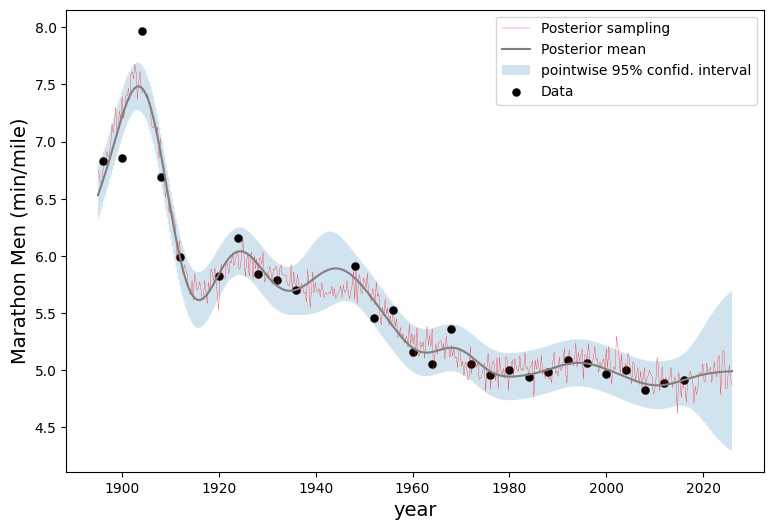

In [34]:
gp_olympic_event(marathon['Year'], marathon['Minutes per Mile'], GaussianK_fun, mu_fun, (5/60)**2, "Marathon Men (min/mile)") ##mu=5

* How you chose the kernel, mean, and noise.

I chose the noise by estimating the uncertainty of the timing and random factors like wind, weather and so on. I chose the width of the kernel by the number of years between two Olympics. I chose the mean by estimating the average of the latest several Olympics.
* Why the plot does or doesn't look satisfactory to you

The plot looks good to me. Nearly all the data points are within the 95% confidence interval
* If there are any events such as the 1904 marathon that are notable.

Yes, the 1904 St. Louis Olympics.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data?

The posterior mean in the gap does not deviate a lot from the closest two data points, while the confidence interval becomes larger.

###Women's Marathon

In [35]:
marathonW = dat[dat['Event'] == 'Marathon Women']
marathonW = marathonW[marathonW['Medal']=='G']
marathonW = marathonW.sort_values('Year')
time = np.array(marathonW['Result'])
mpm = []
for tm in time:
    t = np.array(tm.split(':'), dtype=float)
    minutes_per_mile = (t[0]*60*60 + t[1]*60 + t[2])/(60*26.2)
    mpm.append(minutes_per_mile)

marathonW['Minutes per Mile'] = np.round(mpm,2)
marathonW = marathonW.drop(columns=['Gender', 'Event'], axis=1)
marathonW.reset_index(drop=True, inplace=True)
year = np.array(marathonW['Year'])
result = np.array(marathonW['Minutes per Mile'])
marathonW

,Location,Year,Medal,Name,Nationality,Result,Minutes per Mile
0,Los Angeles,1984,G,Joan BENOIT,USA,2:24:52,5.53
1,Seoul,1988,G,Rosa MOTA,POR,2:25:40,5.56
2,Barcelona,1992,G,Valentina YEGOROVA,EUN,2:32:41,5.83
3,Atlanta,1996,G,Fatuma ROBA,ETH,2:26:05,5.58
4,Sydney,2000,G,Naoko TAKAHASHI,JPN,02:23:14,5.47
5,Athens,2004,G,Mizuki NOGUCHI,JPN,2:26:20,5.59
6,Beijing,2008,G,Constantina TOMESCU,ROU,2:26:44,5.60
7,London,2012,G,Tiki GELANA,ETH,2:23:07,5.46
8,Rio,2016,G,Jemima Jelagat SUMGONG,KEN,2:24:04,5.50


0

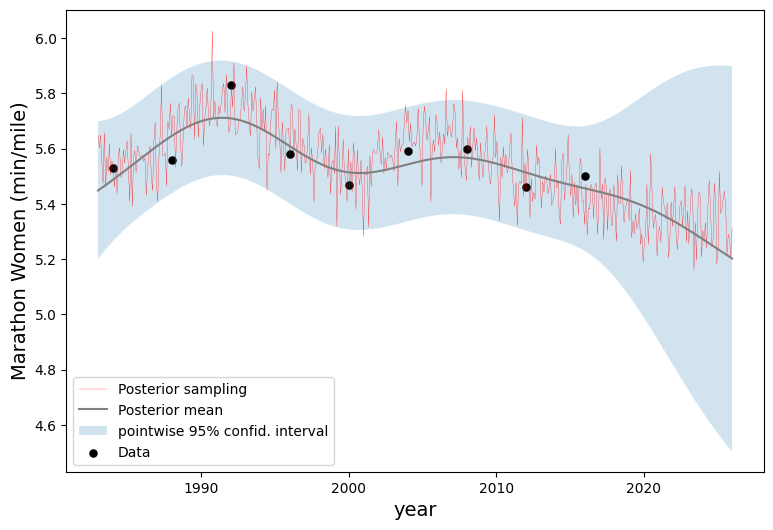

In [36]:
gp_olympic_event(marathonW['Year'], marathonW['Minutes per Mile'], GaussianK_fun, mu_fun, (5/60)**2, "Marathon Women (min/mile)") ##mu=5

* How you chose the kernel, mean, and noise.

I chose the noise by estimating the uncertainty of the timing and random factors like wind, weather and so on. I chose the width of the kernel by the number of years between two Olympics. I chose the mean by estimating the average of the latest several Olympics.
* Why the plot does or doesn't look satisfactory to you

The plot looks good to me. Al the data points are within the 95% confidence interval
* If there are any events such as the 1904 marathon that are notable.

No.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data?

There are no gaps in the data.

###110M Hurdles Men

In [37]:
HurdlesM = dat[dat['Event'] == '110M Hurdles Men']
HurdlesM = HurdlesM[HurdlesM['Medal']=='G']
HurdlesM = HurdlesM.sort_values('Year')
time = np.array(HurdlesM['Result'])
time = time.astype(float)

HurdlesM['Time(sec)'] = time
HurdlesM = HurdlesM.drop(columns=['Gender', 'Event', 'Result'], axis=1)
HurdlesM.reset_index(drop=True, inplace=True)

HurdlesM

,Location,Year,Medal,Name,Nationality,Time(sec)
0,Athens,1896,G,Thomas CURTIS,USA,17.60
1,Paris,1900,G,Alvin KRAENZLEIN,USA,15.40
2,St Louis,1904,G,Frederick SCHULE,USA,16.00
3,London,1908,G,Forrest SMITHSON,USA,15.00
4,Stockholm,1912,G,Frederick KELLY,USA,15.10
5,Antwerp,1920,G,Earl THOMSON,CAN,14.80
6,Paris,1924,G,Daniel KINSEY,USA,15.00
7,Amsterdam,1928,G,Sidney ATKINSON,RSA,14.80
8,Los Angeles,1932,G,George SALING,USA,14.60
9,Berlin,1936,G,Forrest TOWNS,USA,14.20


0

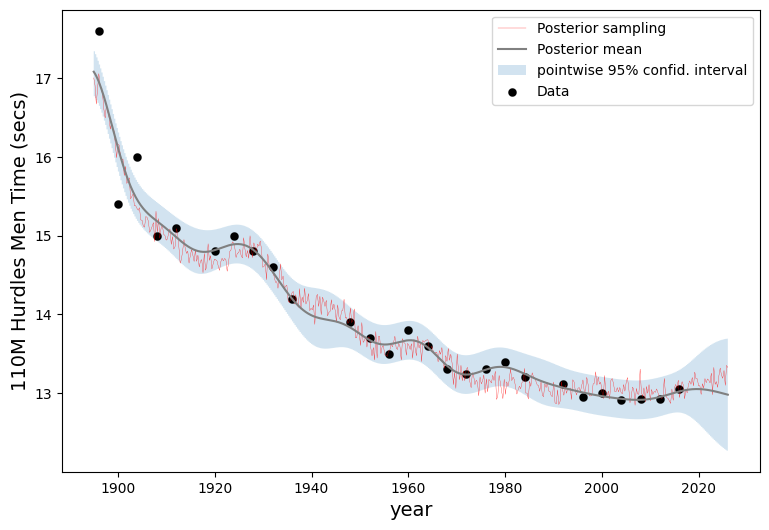

In [43]:
gp_olympic_event(HurdlesM['Year'], HurdlesM['Time(sec)'], GaussianK_fun, mu_fun, 0.1**2, "110M Hurdles Men Time (secs)") ##mu = 12.88

* How you chose the kernel, mean, and noise.

I chose the noise by estimating the uncertainty of the timing and random factors like wind, weather and so on. I chose the width of the kernel by the number of years between two Olympics. I chose the mean by estimating the average of the latest several Olympics.
* Why the plot does or doesn't look satisfactory to you

The plot looks good to me. Nearly all the data points are within the 95% confidence interval
* If there are any events such as the 1904 marathon that are notable.

Yes, the first 3 Olympics. Perhaps it's due to the technique of the event is not optimized yet.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data?

The posterior mean in the gap does not deviate a lot from the closest two data points, while the confidence interval becomes larger.

###100M Hurdles Women

In [44]:
HurdlesW = dat[dat['Event'] == '100M Hurdles Women']
HurdlesW = HurdlesW[HurdlesW['Medal']=='G']
HurdlesW = HurdlesW.sort_values('Year')
time = np.array(HurdlesW['Result'])
time = time.astype(float)

HurdlesW['Time(sec)'] = time
HurdlesW = HurdlesW.drop(columns=['Gender', 'Event', 'Result'], axis=1)
HurdlesW.reset_index(drop=True, inplace=True)

HurdlesW

,Location,Year,Medal,Name,Nationality,Time(sec)
0,Munich,1972,G,Annelie EHRHARDT,GDR,12.59
1,Montreal,1976,G,Johanna SCHALLER-KLIER,GDR,12.77
2,Moscow,1980,G,Vera KOMISOVA,URS,12.56
3,Los Angeles,1984,G,Benita FITZGERALD-BROWN,USA,12.84
4,Barcelona,1992,G,Voula PATOULIDOU,GRE,12.64
5,Atlanta,1996,G,Ludmila ENGQUIST,SWE,12.58
6,Sydney,2000,G,Olga SHISHIGINA,KAZ,12.65
7,Athens,2004,G,Joanna HAYES,USA,12.37
8,Beijing,2008,G,Dawn HARPER,USA,12.54
9,London,2012,G,Sally PEARSON,AUS,12.35


0

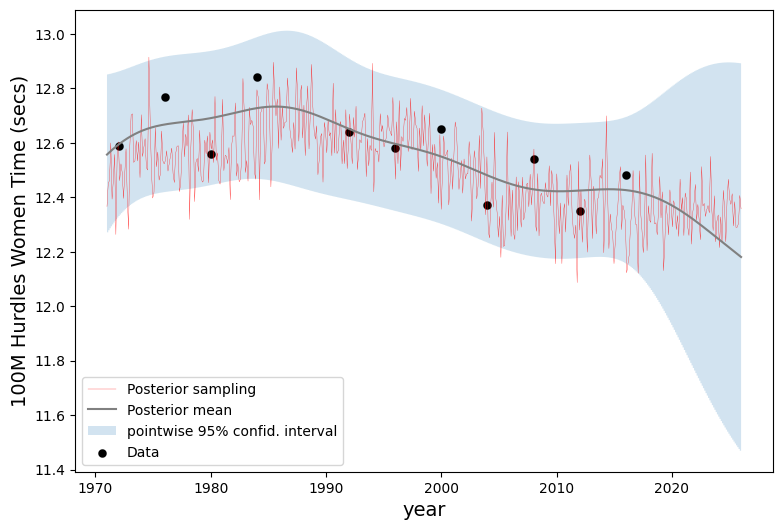

In [46]:
gp_olympic_event(HurdlesW['Year'], HurdlesW['Time(sec)'], GaussianK_fun, mu_fun, 0.1**2, "100M Hurdles Women Time (secs)") ##mu = 12

* How you chose the kernel, mean, and noise.

I chose the noise by estimating the uncertainty of the timing and random factors like wind, weather and so on. I chose the width of the kernel by the number of years between two Olympics. I chose the mean by estimating the average of the latest several Olympics.
* Why the plot does or doesn't look satisfactory to you

The plot looks good to me. Al the data points are within the 95% confidence interval
* If there are any events such as the 1904 marathon that are notable.

No.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data?

The posterior mean in the gap does not deviate a lot from the closest two data points, while the confidence interval becomes larger.

###High Jump Men

In [47]:
HighJumpMen = dat[dat['Event'] == 'High Jump Men']
HighJumpMen = HighJumpMen[HighJumpMen['Medal']=='G']
HighJumpMen = HighJumpMen.sort_values('Year')
height = np.array(HighJumpMen['Result'])
height = height.astype(float)

HighJumpMen['Height(m)'] = height
HighJumpMen = HighJumpMen.drop(columns=['Gender', 'Event', 'Result'], axis=1)
HighJumpMen.reset_index(drop=True, inplace=True)

HighJumpMen

,Location,Year,Medal,Name,Nationality,Height(m)
0,Athens,1896,G,Ellery CLARK,USA,1.81
1,Paris,1900,G,Irving BAXTER,USA,1.90
2,St Louis,1904,G,Samuel JONES,USA,1.80
3,London,1908,G,Harry PORTER,USA,1.90
4,Stockholm,1912,G,Alma RICHARDS,USA,1.93
5,Paris,1924,G,Harold OSBORN,USA,1.98
6,Los Angeles,1932,G,Duncan MCNAUGHTON,CAN,1.97
7,Helsinki,1952,G,Walt DAVIS,USA,2.04
8,Rome,1960,G,Robert SHAVLAKADZE,URS,2.16
9,Tokyo,1964,G,Valeri BRUMEL,URS,2.18


0

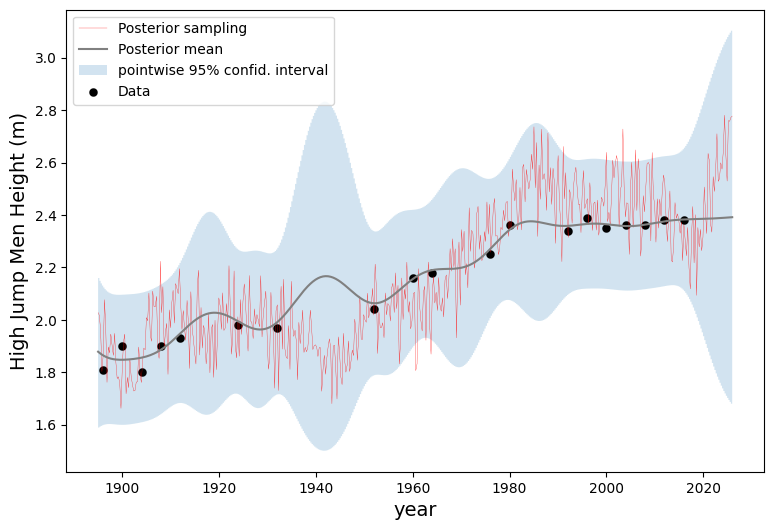

In [51]:
gp_olympic_event(HighJumpMen['Year'], HighJumpMen['Height(m)'], GaussianK_fun, mu_fun, 0.1**2, "High Jump Men Height (m)") ##mu = 2.4

* How you chose the kernel, mean, and noise.

I chose the noise by estimating the uncertainty of the timing and random factors like wind, weather and so on. I chose the width of the kernel by the number of years between two Olympics. I chose the mean by estimating the average of the latest several Olympics.
* Why the plot does or doesn't look satisfactory to you

The plot looks good to me. Al the data points are within the 95% confidence interval
* If there are any events such as the 1904 marathon that are notable.

No.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data?

The posterior mean in the gap forms a peak between the closest two data points, while the confidence interval becomes larger.

###High Jump Women

In [63]:
HighJumpWomen = dat[dat['Event'] == 'High Jump Women']
HighJumpWomen = HighJumpWomen[HighJumpWomen['Medal']=='G']
HighJumpWomen = HighJumpWomen.sort_values('Year')
height = np.array(HighJumpWomen['Result'])
height = height.astype(float)

HighJumpWomen['Height(m)'] = height
HighJumpWomen = HighJumpWomen.drop(columns=['Gender', 'Event', 'Result'], axis=1)
HighJumpWomen = HighJumpWomen.drop(HighJumpWomen.index[14])
HighJumpWomen.reset_index(drop=True, inplace=True)

HighJumpWomen

,Location,Year,Medal,Name,Nationality,Height(m)
0,Los Angeles,1932,G,Jean SHILEY,USA,1.65
1,Berlin,1936,G,Ibolya CSÃK,HUN,1.60
2,London,1948,G,Alice COACHMAN,USA,1.68
3,Helsinki,1952,G,Esther BRAND,RSA,1.67
4,Rome,1960,G,Iolanda BALAS,ROU,1.85
5,Tokyo,1964,G,Iolanda BALAS,ROU,1.90
6,Montreal,1976,G,Rosemarie WITSCHAS-ACKERMANN,GDR,1.93
7,Moscow,1980,G,Sara SIMEONI,ITA,1.97
8,Barcelona,1992,G,Heike HENKEL,GER,2.02
9,Atlanta,1996,G,Stefka KOSTADINOVA,BUL,2.05


0

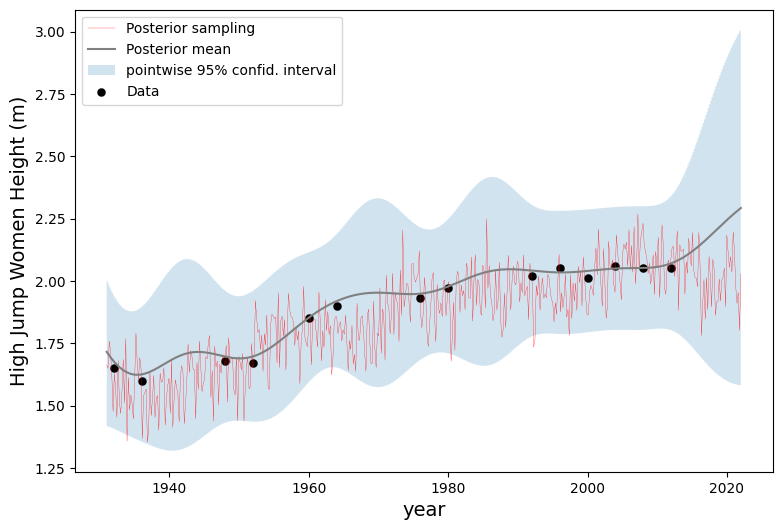

In [65]:
gp_olympic_event(HighJumpWomen['Year'], HighJumpWomen['Height(m)'], GaussianK_fun, mu_fun, 0.1**2, "High Jump Women Height (m)") ##mu = 2.25

* How you chose the kernel, mean, and noise.

I chose the noise by estimating the uncertainty of the timing and random factors like wind, weather and so on. I chose the width of the kernel by the number of years between two Olympics. I chose the mean by estimating the average of the latest several Olympics.
* Why the plot does or doesn't look satisfactory to you

The plot looks good to me. Al the data points are within the 95% confidence interval
* If there are any events such as the 1904 marathon that are notable.

No.
* What happens to the posterior mean (for example during WWII) if there are gaps in the data?

The posterior mean in the gap does not deviate a lot from the closest two data points, while the confidence interval becomes larger.

## Problem 3: Double descent! (20 points)

<a href="https://skitheworld.com/2018/12/wurtele-twins-appointed-order-canada/"><img src="https://raw.githubusercontent.com/YData123/sds365-fa25/main/assignments/assn2/double.jpg" width="200" align="left" style="margin:20px 30px 20px 5px"></a>


In this problem you will explore the "double descent" phenomenon that was recently
discovered as a key principle underlying the performance of deep neural networks.
The problem setup is a "random features" version of a 2-layer neural network. The weights in the first layer are random and fixed, and the weights in the second layer are estimated from data. As we increase the number of neurons in the hidden layer, the dimension $p$ of model increases. It's helpful to define the ratio $\gamma = p/n$ of variables to sample points. If $\gamma < 1$ then we want to use the OLS estimator, and if $\gamma > 1$ we want to use the minimum norm estimator.
<br>

Your mission (should you choose to accept it), is

1. Implement a function `OLS_or_minimum_norm` that computes the least squares solution when $\gamma < 1$, and the minimum norm solution when $\gamma > 1$. (When $\gamma=1$ the estimator does not, in general, exist.)
1. Run the main code we give you to average over many trials, and to compute and plot the estimated risk for a range of values of $\gamma$.
1. Next, extend the starter code so that you compute (estimates of) the squared-bias and variance of the models. To do this, note that you'll need access to the true regression function, which is provided. You may want to refer to the demo code for smoothing kernels as an example.
1. Using your new code, extend the plotting function we provide so that you plot
the squared-bias, variance, and risk together on the same plot.
1. Finally, comment on the results, describing why it might make sense that the squared bias, variance, and risk have the given shapes that they do.
1. Show that in the overparameterized regime $\gamma > 1$, as $\lambda \to 0$, the ridge regression estimator converges to the minimum norm estimator.


By doing this exercise you will solidify your understanding of the meaning of bias and variance, and also gain a better understanding of the "double descent" phenomenon for overparameterized neural networks,
and their striking resistance to overfitting.

We're available in OH to help with any issues you run into!

If you have any interest in background reading on this topic (not expected or required), we recommend Hastie et al., ["Surprises in high-dimensional ridgeless least squares regression"](https://www.stat.cmu.edu/~ryantibs/papers/ridgeless.pdf).



In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Problem 3.1

Implement the function `OLS_or_minimum_norm` that computes the OLS solution for $\gamma < 1$, and the minimum norm solution for $\gamma > 1$.

In [53]:
def OLS_or_minimum_norm(X, y):
  gamma = X.shape[1]/X.shape[0]
  if gamma < 1:
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y #OLS solution
  elif gamma > 1:
    beta_hat = X.T @ np.linalg.inv(X @ X.T) @ y #Minimum norm solution
  else:
    return 0
  return beta_hat

In [54]:
# A plotting function we provide. No need to change this, although you can if you'd like.

def plot_double_descent_risk(gammas, risk, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10,6))
    tick_pos = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9
    ax.axvline(x=tick_pos[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')
    ax.scatter(tick_pos, risk, color='salmon')
    ax.plot(tick_pos, risk, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    _ = plt.ylabel('Risk', fontsize=18)

### Data setup

The following cell sets up our data. The inputs $X$ are
random Gaussian vectors of dimension $d=10$. Then, we map these
using a neural network with fixed, Gaussian weights, to get random features
corresponding to $p^* = 150$ hidden neurons. The second layer
coefficients are $\beta^* \in {\mathbb R}^{p^*}$, which are fixed.
This defines the true model.


In [55]:
# just execute this cell, after you define the function above.

np.random.seed(123456)

sigma = 1
d = 10
p_star = 150
signal_size = 5

W_star = (1/np.sqrt(d)) * np.random.randn(d, p_star)
beta_star = np.arange(p_star)
beta_star = signal_size * beta_star / np.sqrt(np.sum(beta_star**2))

N = 10000
X = np.random.randn(N, d)

# f_star is the true regression function, for computing the squared bias
f_star = np.dot(np.tanh(np.dot(X, W_star)), beta_star)
noise = sigma * np.random.randn(N)
y = f_star + noise
yf = np.concatenate((y.reshape(N,1), f_star.reshape(N,1)), axis=1)

### Train a sequence of models for different values of $\gamma$

Next, we train a sequence of models for different values of $\gamma$, always
fixing the sample size at $n=200$, but varying the dimension $p = \gamma n$.
When $p < p^*$ we just take the first $p$ features in the true model.
When $p > p^*$ we add $p-p^*$ neurons to the hidden layer, with their
own random weights.

In the code below, we loop over the different values of $\gamma$,
and for each $\gamma$ we run $100$ trials, each time generating
a new training set of size $n=200$. The model (either OLS or minimum norm) is then computed, the MSE is computed, and finally the risk is estimated by averaging over all $100$ trials.


In [56]:
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []
for gamma in gammas:
    err = []
    p = int(n * gamma)
    if gamma == 1:
        risk.append(np.inf)
        continue
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]
    for i in np.arange(trials):
        X_train, X_test, yf_train, yf_test = train_test_split(X, yf, train_size=n, test_size=1000)
        H_train = np.tanh(np.dot(X_train, W))
        H_test = np.tanh(np.dot(X_test, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat
        err.append(np.mean((yhat_test - yf_test[:,0])**2))
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f' % (gamma, p, n, np.mean(err)))
    risk.append(np.mean(err))


gamma=0.01  p=2  n=200  risk=7.373
gamma=0.05  p=10  n=200  risk=4.146
gamma=0.10  p=20  n=200  risk=2.294
gamma=0.20  p=40  n=200  risk=2.099
gamma=0.30  p=60  n=200  risk=2.267
gamma=0.40  p=80  n=200  risk=2.534
gamma=0.50  p=100  n=200  risk=3.011
gamma=0.60  p=120  n=200  risk=3.573
gamma=0.70  p=140  n=200  risk=4.443
gamma=0.80  p=160  n=200  risk=6.885
gamma=0.90  p=180  n=200  risk=15.773
gamma=0.92  p=184  n=200  risk=20.500
gamma=0.94  p=188  n=200  risk=31.661
gamma=1.10  p=220  n=200  risk=24.179
gamma=1.20  p=240  n=200  risk=14.097
gamma=1.40  p=280  n=200  risk=8.089
gamma=1.60  p=320  n=200  risk=6.543
gamma=2.00  p=400  n=200  risk=5.301
gamma=3.00  p=600  n=200  risk=4.073
gamma=4.00  p=800  n=200  risk=3.658
gamma=5.00  p=1000  n=200  risk=3.430
gamma=6.00  p=1200  n=200  risk=3.309
gamma=7.00  p=1400  n=200  risk=3.135
gamma=8.00  p=1600  n=200  risk=3.190
gamma=9.00  p=1800  n=200  risk=3.056
gamma=10.00  p=2000  n=200  risk=3.062


### Plot the risk

At this point, you can plot the risk by just evaluating the cell below.
This should reveal the "double descent" behavior.


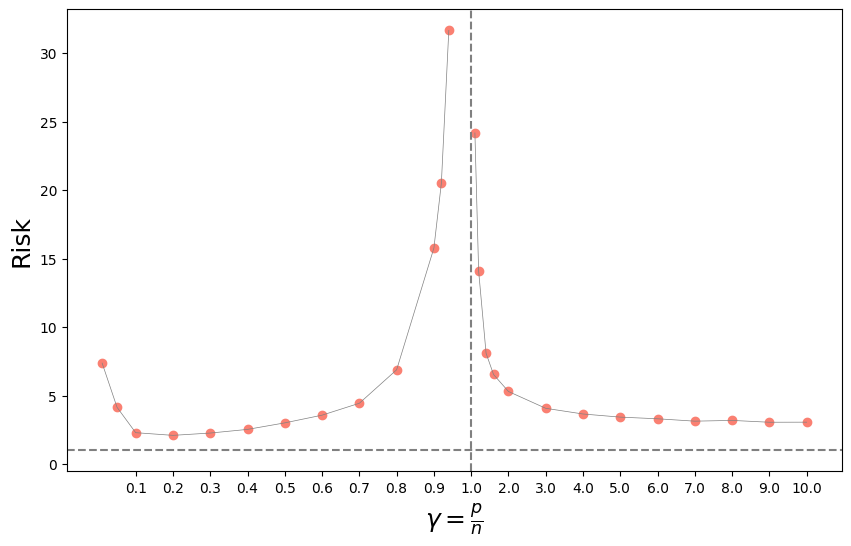

In [57]:
# Just evaluate the next line
plot_double_descent_risk(gammas, risk, sigma)

### Problem 3.2

Comment on the results. Explain why the risk plot does or does not make sense
in each regime: The underparameterized regime $\gamma < 1$, and the overparameterized
regime $\gamma > 1$. Is the curve "U-shaped" in the underparameterized regime? Why or why not?
What about in the overparameterized regime? You will be able to give better answers to these questions when you estimate the bias and variance below.


The risk plot makes sense. In the $\gamma < 1$ underparameterized regime, the curve is \"U-shaped\" which goes into overfitting when $\gamma > 0.2$. In the overparameterized $\gamma > 1$ regime, the risk monotonically decreases with $\gamma$ increasing."
      

### Problem 3.3

Now, modify the above code so that you can estimate both the squared bias and the
variance of the estimator. Before you do this, you may want to revisit the kernel smoothing demo from class, where we computed the squared bias, variance, and risk. You'll need the true function, which is provided in the variable `yf`.  You should not have to write a lot of code, but can compute the bias and variance after you store the predicted values on the test data for each trial.

Plot the results, by plotting both the squared bias, the variance, and the risk for the sequence of gammas. To do this you will have to modify the plotting function appropriately, but this again involves minimal changes. When you obtain your final plot, comment
on the shape of the bias and variance curves, as above for Problem 3.2.


In [61]:
# Plot squared bias and variance as well
def plot_double_descent_risk_bias2_variance(gammas, risk, bias2, variance, sigma):
    gammas = np.round(gammas, 2)
    fig, ax = plt.subplots(figsize=(10,6))
    tick_pos = np.zeros(len(gammas))
    for i in np.arange(len(gammas)):
        if gammas[i] <= 1:
            tick_pos[i] = gammas[i] * 10
        else:
            tick_pos[i] = gammas[i] + 9
    ax.axvline(x=tick_pos[np.array(gammas)==1][0], linestyle='dashed', color='gray')
    ax.axhline(y=sigma**2, linestyle='dashed', color='gray')
    ax.scatter(tick_pos, risk, color='salmon', label = 'Risk')
    ax.plot(tick_pos, risk, color='gray', linewidth=.5)

    ax.scatter(tick_pos, bias2, color='green', label = 'sq_bias')
    ax.plot(tick_pos, bias2, color='gray', linewidth=.5)

    ax.scatter(tick_pos, variance, color='blue', label = 'Variance')
    ax.plot(tick_pos, variance, color='gray', linewidth=.5)

    tickgam = [gam for gam in gammas if (gam > .05 and gam <= .9) or gam >= 2 or gam == 1]
    ticks = [tick_pos[j] for j in np.arange(len(tick_pos)) if gammas[j] in tickgam]
    ax.xaxis.set_ticks(ticks)
    ax.xaxis.set_ticklabels(tickgam)

    ax.legend()

    plt.xlabel(r'$\gamma = \frac{p}{n}$', fontsize=18)
    _ = plt.ylabel('Risk', fontsize=18)

In [59]:
# Parts commented out are another way to calculate the risk, squared bias and variance.
trials = 100
n = 200

gammas = list(np.arange(.1, 1, .1)) + [.92, .94, 1, 1.1, 1.2, 1.4, 1.6] + list(np.arange(2, 11, 1))
gammas = [.01, .05] + gammas
risk = []
bias2 = []
variance = []

for gamma in gammas:
    err = []
    fhat = np.zeros(1000)
    fhat2 = np.zeros(1000)
    #estimates = []
    p = int(n * gamma)
    if gamma == 1:
        risk.append(np.inf)
        bias2.append(0)
        variance.append(np.inf)
        continue
    W = (1/np.sqrt(d)) * np.random.randn(d, p)
    W[:,:min(p, p_star)] = W_star[:,:min(p, p_star)]
    #fix test set
    X_test = X[0:1000]
    yf_test = yf[0:1000]
    H_test = np.tanh(np.dot(X_test, W))
    for i in np.arange(trials):
        X_train, X_placeholder, yf_train, yf_placeholder = train_test_split(X[1000:,:], yf[1000:], train_size=n)
        H_train = np.tanh(np.dot(X_train, W))
        beta_hat = OLS_or_minimum_norm(H_train, yf_train[:,0])
        yhat_test = H_test @ beta_hat

        err.append(np.mean((yhat_test - yf_test[:,0])**2))
        fhat = fhat + yhat_test
        fhat2 = fhat2 + yhat_test**2
        Efhat = fhat/trials
        Efhat2 = fhat2/trials

    #    estimates.append(yhat_test)
    #estimates = np.array(estimates)
    #print('gamma=%.2f  p=%d  n=%d  risk=%.3f  bias2 = %.3f  variance = %.3f' % (gamma, p, n, np.mean((estimates - yf_test[:,0].reshape(1,-1))**2),np.mean((np.mean(estimates,axis = 0)-yf_test[:,1])**2),np.mean(np.var(estimates,axis = 0))))
    print('gamma=%.2f  p=%d  n=%d  risk=%.3f  bias2 = %.3f  variance = %.3f' % (gamma, p, n, np.mean(err),np.mean((Efhat-yf_test[:,1])**2),np.mean(Efhat2-Efhat**2)))
    risk.append(np.mean(err))
    bias2.append(np.mean((Efhat-yf_test[:,1])**2))
    variance.append(np.mean(Efhat2-Efhat**2))

gamma=0.01  p=2  n=200  risk=7.650  bias2 = 6.522  variance = 0.071
gamma=0.05  p=10  n=200  risk=4.317  bias2 = 3.016  variance = 0.204
gamma=0.10  p=20  n=200  risk=2.146  bias2 = 1.011  variance = 0.226
gamma=0.20  p=40  n=200  risk=2.012  bias2 = 0.639  variance = 0.447
gamma=0.30  p=60  n=200  risk=2.227  bias2 = 0.517  variance = 0.769
gamma=0.40  p=80  n=200  risk=2.443  bias2 = 0.431  variance = 1.081
gamma=0.50  p=100  n=200  risk=2.938  bias2 = 0.390  variance = 1.624
gamma=0.60  p=120  n=200  risk=3.571  bias2 = 0.262  variance = 2.360
gamma=0.70  p=140  n=200  risk=4.555  bias2 = 0.150  variance = 3.452
gamma=0.80  p=160  n=200  risk=6.779  bias2 = 0.076  variance = 5.719
gamma=0.90  p=180  n=200  risk=15.618  bias2 = 0.183  variance = 14.470
gamma=0.92  p=184  n=200  risk=20.971  bias2 = 0.213  variance = 19.755
gamma=0.94  p=188  n=200  risk=29.726  bias2 = 0.289  variance = 28.441
gamma=1.10  p=220  n=200  risk=23.485  bias2 = 0.230  variance = 22.304
gamma=1.20  p=240  

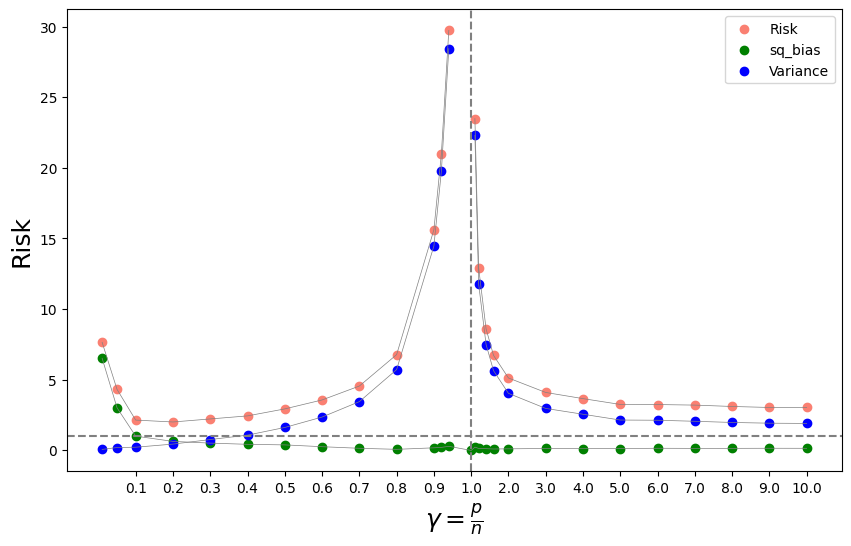

In [62]:
plot_double_descent_risk_bias2_variance(gammas, risk, bias2, variance, sigma)

The plot is what we expect. When $\gamma$ approaching 1, the squared bias decreases and goes to 0 while the variance increases. As a result, in the underparametrized region, the risk curve is "U-shaped". Howeverm in the overparametrized region, the squared bias changes little, and the variance decreases as $\gamma$ becomes larger. As a result, the risk decreases and this decreasing is call "double descent".

### Problem 3.4

In class, we discussed the interpretation of the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. Geometrically, we can describe $ \hat{\beta}_{\text{mn}} $ as the orthogonal projection of the zero vector in $ \mathbb{R}^p $ onto the $ (p-1) $-dimensional hyperplane $ \{ \beta : X\beta = Y \} $.  

This can also be viewed as "ridgeless" regression. In ridge regression, we minimize the objective function
$$
\| Y - X\beta  \|_2^2 + \lambda \| \beta \|_2^2,
$$
which has the closed-form solution
$$
\hat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y.
$$

In the overparameterized regime where $ p > n $, it can be shown that as $ \lambda \to 0 $, $ \hat{\beta}_{\lambda} $ converges to $ \hat{\beta}_{\text{mn}} $.

Your task is to show that as $ \lambda \to 0 $, the limit of the ridge regression estimator $ \hat{\beta}_{\lambda} $, in the overparameterized regime where $ \gamma > 1 $, is the minimum-norm estimator $ \hat{\beta}_{\text{mn}} $. You may want to use the Woodbury formula for this derivation.


_Hint_:
1. Applying the simplified version of Woodbury formula
$$
(I + UV^T)^{-1} = I - U(I + V^T U)^{-1} V^T.
$$
we can derive the identity:
$$
(X^T X + \lambda I_p)^{-1} X^T = X^T (X X^T + \lambda I_n)^{-1},
$$
2. You might consider using the Woodbury formula twice.



Using the Woodbury formula, let $U=V=Y$,
$$(I_n+YY^T)^{-1}=I_n-Y(I_p+Y^TY)^{-1}Y^T$$
$$Y^T(I_n+YY^T)^{-1}=Y^T-Y^TY(I_p+Y^TY)^{-1}Y^T$$
$$=(I_p+Y^TY)(I_p+Y^TY)^{-1}Y^T-Y^TY(I_p+Y^TY)^{-1}Y^T$$
$$=I_p(I_p+Y^TY)^{-1}Y^T.$$
So $$Y^T(I_n+YY^T)^{-1}=(I_p+Y^TY)^{-1}Y^T.$$
Let $X=\sqrt{\lambda}Y$,
$$X^T(I_n+XX^T/\lambda)^{-1}=(I_p+X^TX/\lambda)^{-1}X^T$$
$$X^T(\lambda I_n+XX^T)^{-1}=(\lambda I_p+X^TX)^{-1}X^T.$$
So
$$\widehat{\beta}_{\lambda} = (X^T X + \lambda I)^{-1} X^T Y=X^T(\lambda I_n+XX^T)^{-1}Y$$
$$\mbox{lim}_{\lambda\rightarrow 0}\widehat{\beta}_{\lambda} = X^T(XX^T)^{-1}Y = \widehat{\beta}_{mn}$$